In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

In [2]:
dir_dados = '../2_dados/'
arq_treino_sumario = dir_dados + '/treino_teste/treino_sumario.parquet'
arq_treino = dir_dados + '/treino_teste/treino.npy'
arq_teste_sumario = dir_dados + '/treino_teste/teste_sumario.parquet'
arq_teste = dir_dados + '/treino_teste/teste.npy'

#### Abre arquivos

In [3]:
treino_idx = pd.read_parquet(arq_treino_sumario)    # Possui o target do treino
teste_idx = pd.read_parquet(arq_teste_sumario)      # Possui o target do teste

In [4]:
print('Treino:')
print(treino_idx['target'].value_counts())

Treino:
1    24
0    24
Name: target, dtype: int64


In [5]:
print('Teste:')
print(teste_idx['target'].value_counts())

Teste:
0    140
1     11
Name: target, dtype: int64


In [6]:
treino = np.load(arq_treino)
teste = np.load(arq_teste)

In [7]:
#treino = treino.reshape(-1, treino.shape[1], 1)
#teste = teste.reshape(-1, teste.shape[1], 1)

In [8]:
print('Dimensão de Treino:', treino.shape)
print('Dimensão de Teste:', teste.shape)

Dimensão de Treino: (48, 400, 7)
Dimensão de Teste: (151, 400, 7)


In [9]:
treino_true = treino_idx['target'].to_numpy().reshape(-1, 1)
teste_true = teste_idx['target'].to_numpy().reshape(-1, 1)

### Classificador binário com LSTM

model = keras.Sequential()
model.add(layers.LSTM(1000, return_sequences=True, input_shape=(treino.shape[1], treino.shape[2])))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(500, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(250, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

In [103]:
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(treino.shape[1], treino.shape[2]), recurrent_regularizer=keras.regularizers.l2(0.1)))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(200, activation='relu'))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(100, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               43200     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [104]:
history = model.fit(treino, treino_true, epochs=100, batch_size=20, validation_data=(teste, teste_true))

Epoch 1/100
3/3 [==============================] - 1s 332ms/step - loss: 10.4534 - precision_14: 0.5161 - recall_14: 0.6667 - val_loss: 9.7873 - val_precision_14: 0.0814 - val_recall_14: 0.6364
Epoch 2/100
3/3 [==============================] - 1s 215ms/step - loss: 9.5309 - precision_14: 0.5484 - recall_14: 0.7083 - val_loss: 8.9227 - val_precision_14: 0.0658 - val_recall_14: 0.4545
Epoch 3/100
3/3 [==============================] - 1s 215ms/step - loss: 8.6813 - precision_14: 0.6000 - recall_14: 0.6250 - val_loss: 8.1317 - val_precision_14: 0.0678 - val_recall_14: 0.3636
Epoch 4/100
3/3 [==============================] - 1s 217ms/step - loss: 7.9090 - precision_14: 0.6400 - recall_14: 0.6667 - val_loss: 7.4526 - val_precision_14: 0.0714 - val_recall_14: 0.5455
Epoch 5/100
3/3 [==============================] - 1s 216ms/step - loss: 7.2071 - precision_14: 0.6429 - recall_14: 0.7500 - val_loss: 6.8035 - val_precision_14: 0.0870 - val_recall_14: 0.5455
Epoch 6/100
3/3 [=================

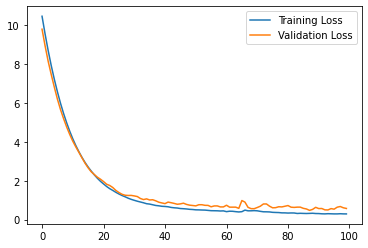

In [105]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [106]:
treino_pred = (model.predict(treino) > 0.5).astype("int32")

In [107]:
metrics = precision_recall_fscore_support(treino_true, treino_pred, pos_label=1, average='binary')
print('Precisão:', round(metrics[0], 2))
print('Recall:', round(metrics[1], 2))
print('f1:', round(metrics[2], 2))

Precisão: 1.0
Recall: 0.83
f1: 0.91


### Teste

In [108]:
teste_pred = (model.predict(teste) > 0.5).astype("int32")

In [109]:
metrics = precision_recall_fscore_support(teste_true, teste_pred, pos_label=1, average='binary')
print('Precisão:', round(metrics[0], 2))
print('Recall:', round(metrics[1], 2))
print('f1:', round(metrics[2], 2))

Precisão: 0.23
Recall: 0.73
f1: 0.35


In [110]:
cf_matrix = confusion_matrix(teste_true, teste_pred)
print(cf_matrix)

[[113  27]
 [  3   8]]


<AxesSubplot:>

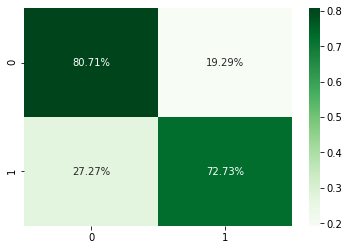

In [111]:
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Greens')

In [112]:
print(classification_report(teste_true, teste_pred, target_names=['Normal', 'Descarga Parcial']))

                  precision    recall  f1-score   support

          Normal       0.97      0.81      0.88       140
Descarga Parcial       0.23      0.73      0.35        11

        accuracy                           0.80       151
       macro avg       0.60      0.77      0.62       151
    weighted avg       0.92      0.80      0.84       151

